In [59]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import preprocessing, metrics
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Ridge, Lasso, SGDRegressor
from sklearn.metrics import  make_scorer,  mean_squared_error
%matplotlib inline
from scipy.stats import skew, skewtest, norm
from xgboost.sklearn import XGBRegressor
import scipy.stats as st
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [60]:
from catboost import Pool, CatBoostRegressor


In [62]:
from scipy.stats import skew, skewtest, norm

In [64]:
import seaborn as sns

In [65]:
data = pd.read_csv('ml_eng_ay_data.csv')

In [66]:
data.head()

,date,cnt_rooms,flat_area,rent_base,rent_total,flat_type,flat_interior_quality,flat_condition,flat_age,flat_thermal_characteristic,has_elevator,has_balcony,has_garden,has_kitchen,has_guesttoilet,geo_city,geo_city_part
0,2018-09-15,1,36.00,530.0,650.0,apartment,average,good,60+,NaN,f,t,t,t,f,hamburg,wandsbek
1,2018-09-15,2,70.00,1100.0,1280.0,appartment,average,good,60+,NaN,t,t,f,t,f,hamburg,mitte
2,2018-09-15,2,62.13,1040.0,1220.0,apartment,sophisticated,first_time_use,<5,NaN,t,t,f,t,t,hamburg,altona
3,2018-09-15,2,75.00,675.0,950.0,roof_storey,average,good,<30,104.0,f,t,f,t,t,hamburg,wandsbek
4,2018-09-15,2,52.00,676.0,810.0,apartment,average,good,60+,NaN,f,t,f,t,f,hamburg,hamburg-nord


In [67]:
# data['log_rent_total'] = np.log1p(data.rent_total)

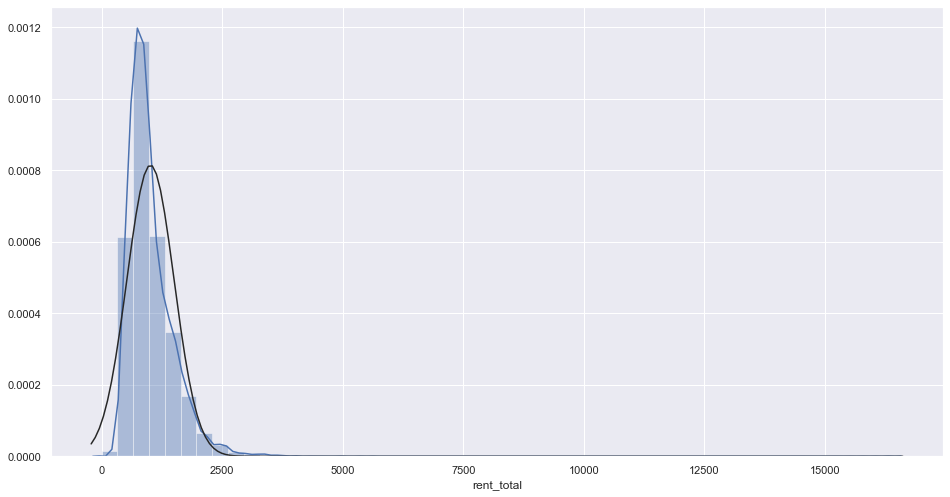

In [68]:
sns.set(rc={'figure.figsize':(16,8.27)})

sns.distplot(data['rent_total'], fit=norm)

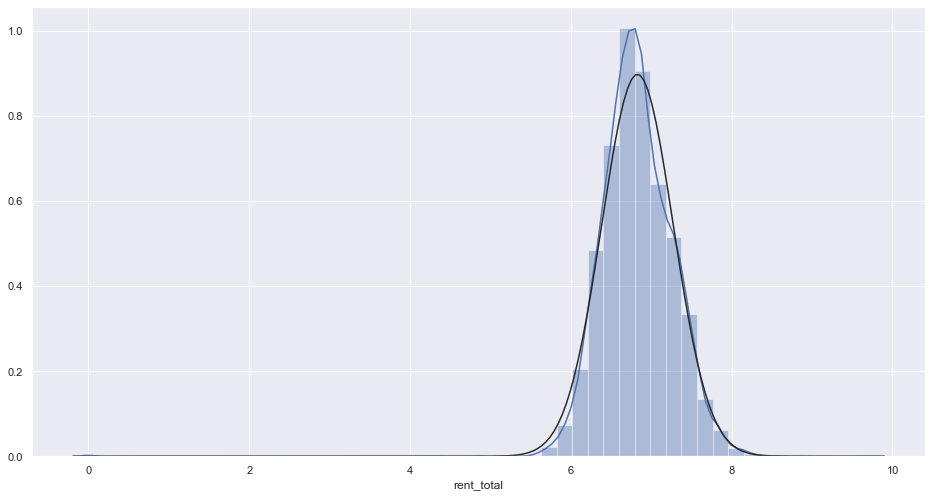

In [70]:
sns.set(rc={'figure.figsize':(16,8.27)})

sns.distplot(np.log1p(data['rent_total']), fit=norm)

In [71]:
print("Skewness: %f" % data['rent_total'].skew())
print("Kurtosis: %f" % data['rent_total'].kurt())

Skewness: 3.801670
Kurtosis: 72.219517


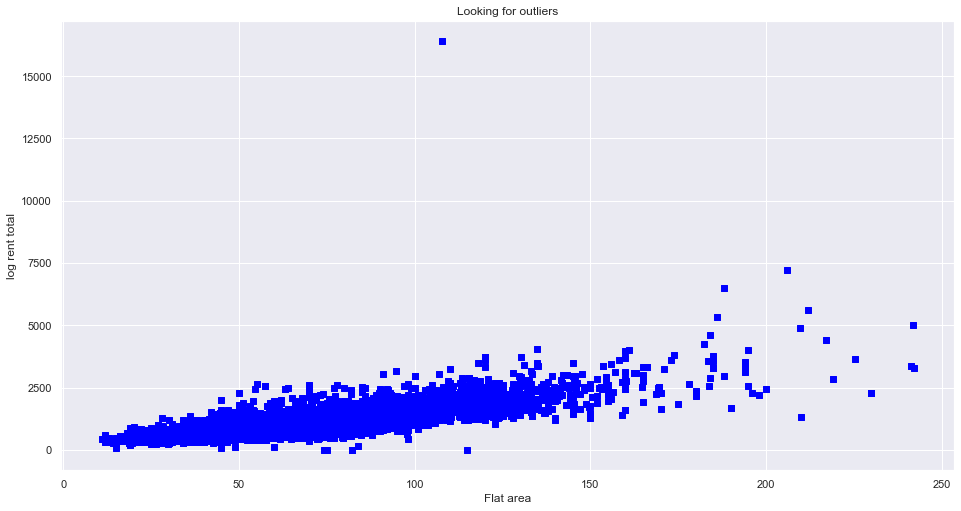

In [103]:
plt.scatter(data.flat_area, data.rent_total, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("Flat area")
plt.ylabel("log rent total")
plt.show()

In [104]:
data.flat_age.unique()

array(['60+', '<5', '<30', '<40', '<60', '<10', '<50', '<20', '<1'],
      dtype=object)

In [105]:
# you have some mistake in label :)

In [106]:
data.flat_type.replace("appartment", "apartment", inplace=True)

In [107]:
data.head()

,date,cnt_rooms,flat_area,rent_base,rent_total,flat_type,flat_interior_quality,flat_condition,flat_age,flat_thermal_characteristic,...,has_garden,has_kitchen,has_guesttoilet,geo_city,geo_city_part,weekday,weekofyear,month,is_weekend,season
0,2018-09-15,1,36.00,530.0,650.0,apartment,average,good,60+,138.3,...,t,t,f,hamburg,wandsbek,5,37,9,True,4
1,2018-09-15,2,70.00,1100.0,1280.0,apartment,average,good,60+,138.3,...,f,t,f,hamburg,mitte,5,37,9,True,4
2,2018-09-15,2,62.13,1040.0,1220.0,apartment,sophisticated,first_time_use,<5,50.7,...,f,t,t,hamburg,altona,5,37,9,True,4
3,2018-09-15,2,75.00,675.0,950.0,roof_storey,average,good,<30,104.0,...,f,t,t,hamburg,wandsbek,5,37,9,True,4
4,2018-09-15,2,52.00,676.0,810.0,apartment,average,good,60+,138.3,...,f,t,f,hamburg,hamburg-nord,5,37,9,True,4


## Feature engineering
#### I add some new features based on our data:
* price per meter
* mean price per meter in city_part
* median  base price per meter in city_part
* median base price in this ditrisct
* median base price of cnt_room 
* is_holiday
* day_of_week
* month
* season 
* mean room ploshad
* 

In [108]:
data[['flat_thermal_characteristic', 'flat_age']].groupby('flat_age').median()

,flat_thermal_characteristic
flat_age,
60+,138.3
<1,57.0
<10,56.0
<20,76.0
<30,104.2
<40,131.7
<5,50.7
<50,135.0
<60,132.0


In [109]:
data['flat_thermal_characteristic'] = data[['flat_thermal_characteristic', 'flat_age']].groupby('flat_age').transform(lambda x: x.fillna(x.median()))

In [110]:
data.loc[data.index == 14957]['flat_age']

14957    <20
Name: flat_age, dtype: object

In [111]:
data['price_per_meter'] = data['rent_base'] / data['flat_area']

In [112]:
data[['price_per_meter', 'geo_city_part']].groupby('geo_city_part').mean()

,price_per_meter
geo_city_part,
altona,13.279246
bergedorf,10.618042
eimsbuettel,13.398530
hamburg-nord,13.701492
harburg,9.480297
mitte,12.958914
wandsbek,11.218225


In [113]:
data.groupby('geo_city_part').mean()

,cnt_rooms,flat_area,rent_base,rent_total,flat_thermal_characteristic,weekday,weekofyear,month,is_weekend,season,price_per_meter
geo_city_part,,,,,,,,,,,
altona,2.567568,70.803360,940.781876,1141.584701,118.133651,2.558559,25.730790,6.325384,0.139375,2.499205,13.279246
bergedorf,2.587855,68.680504,731.367119,913.678811,109.076770,2.263566,26.227390,6.425065,0.091731,2.554264,10.618042
eimsbuettel,2.415725,66.593189,879.969574,1062.897550,119.877880,2.472198,25.826672,6.341877,0.124674,2.533449,13.398530
hamburg-nord,2.409077,65.316109,890.119940,1067.480116,122.056327,2.511197,24.782323,6.119140,0.132278,2.479546,13.701492
harburg,2.534676,65.154027,607.593244,773.307248,122.577681,2.306488,25.437733,6.238628,0.095451,2.512304,9.480297
mitte,2.409170,65.188542,850.430536,1036.995532,120.545852,2.494810,25.578720,6.281142,0.122837,2.515571,12.958914
wandsbek,2.522871,68.808147,765.197589,956.984551,119.391569,2.400334,25.070785,6.164942,0.108180,2.464441,11.218225


In [114]:
data.groupby('geo_city_part').median()

,cnt_rooms,flat_area,rent_base,rent_total,flat_thermal_characteristic,weekday,weekofyear,month,is_weekend,season,price_per_meter
geo_city_part,,,,,,,,,,,
altona,3,68.00,859.00,1032.480,131.7,3,25,6,False,2,13.461538
bergedorf,3,67.00,700.70,870.175,99.5,2,26,6,False,3,10.833333
eimsbuettel,2,63.31,775.00,947.010,131.7,2,26,6,False,3,12.968296
hamburg-nord,2,61.00,795.00,950.000,134.0,2,24,6,False,2,13.416936
harburg,3,64.00,542.32,698.000,132.0,2,25,6,False,3,9.073359
mitte,2,61.00,709.50,880.000,131.7,2,25,6,False,2,12.483750
wandsbek,3,67.00,705.00,882.000,128.0,2,24,6,False,2,10.921080


In [115]:
data.groupby('geo_city').mean()

,cnt_rooms,flat_area,rent_base,rent_total,flat_thermal_characteristic,weekday,weekofyear,month,is_weekend,season,price_per_meter
geo_city,,,,,,,,,,,
hamburg,2.473396,67.043695,830.266037,1014.962983,119.834597,2.455281,25.377005,6.240174,0.120321,2.499666,12.451784


In [116]:
data.groupby('geo_city').median()

,cnt_rooms,flat_area,rent_base,rent_total,flat_thermal_characteristic,weekday,weekofyear,month,is_weekend,season,price_per_meter
geo_city,,,,,,,,,,,
hamburg,2,64.0,733.48,899.025,131.7,2,25,6,False,2,12.0


In [117]:
data['diff_rent_base_and_median_on_city'] = data['rent_base'] - data.groupby('geo_city')['rent_base'].transform('median')
data['diff_rent_base_and_median_on_city_part'] = data['rent_base'] - data.groupby('geo_city_part')['rent_base'].transform('median')

data['diff_rent_base_and_mean_on_city'] = data['rent_base'] - data.groupby('geo_city')['rent_base'].transform('mean')
data['diff_rent_base_and_mean_on_city_part'] = data['rent_base'] - data.groupby('geo_city_part')['rent_base'].transform('mean')

In [118]:
data['diff_price_per_meter_and_median_on_city'] = data['price_per_meter'] - data.groupby('geo_city')['price_per_meter'].transform('median')
data['diff_price_per_meter_and_median_on_city_part'] = data['price_per_meter'] - data.groupby('geo_city_part')['price_per_meter'].transform('median')

data['diff_price_per_meter_and_mean_on_city'] = data['price_per_meter'] - data.groupby('geo_city')['price_per_meter'].transform('mean')
data['diff_price_per_meter_and_mean_on_city_part'] = data['price_per_meter'] - data.groupby('geo_city_part')['price_per_meter'].transform('mean')

In [119]:
data.head()

,date,cnt_rooms,flat_area,rent_base,rent_total,flat_type,flat_interior_quality,flat_condition,flat_age,flat_thermal_characteristic,...,season,price_per_meter,diff_rent_base_and_median_on_city,diff_rent_base_and_median_on_city_part,diff_rent_base_and_mean_on_city,diff_rent_base_and_mean_on_city_part,diff_price_per_meter_and_median_on_city,diff_price_per_meter_and_median_on_city_part,diff_price_per_meter_and_mean_on_city,diff_price_per_meter_and_mean_on_city_part
0,2018-09-15,1,36.00,530.0,650.0,apartment,average,good,60+,138.3,...,4,14.722222,-203.48,-175.0,-300.266037,-235.197589,2.722222,3.801142,2.270438,3.503997
1,2018-09-15,2,70.00,1100.0,1280.0,apartment,average,good,60+,138.3,...,4,15.714286,366.52,390.5,269.733963,249.569464,3.714286,3.230536,3.262502,2.755372
2,2018-09-15,2,62.13,1040.0,1220.0,apartment,sophisticated,first_time_use,<5,50.7,...,4,16.739095,306.52,181.0,209.733963,99.218124,4.739095,3.277557,4.287312,3.459849
3,2018-09-15,2,75.00,675.0,950.0,roof_storey,average,good,<30,104.0,...,4,9.000000,-58.48,-30.0,-155.266037,-90.197589,-3.000000,-1.921080,-3.451784,-2.218225
4,2018-09-15,2,52.00,676.0,810.0,apartment,average,good,60+,138.3,...,4,13.000000,-57.48,-119.0,-154.266037,-214.119940,1.000000,-0.416936,0.548216,-0.701492


In [120]:
data['date'] = pd.to_datetime(data.date)

In [121]:
data['weekday'] = data.date.dt.weekday

In [122]:
data['weekofyear'] = data.date.dt.weekofyear
data['month'] = data.date.dt.month

In [123]:
data['is_weekend'] = data.weekday.isin((5,6))

In [124]:
data['season'] = data.month.apply(lambda dt: (dt %12 + 3)//3)

In [125]:
data.columns

Index(['date', 'cnt_rooms', 'flat_area', 'rent_base', 'rent_total',
       'flat_type', 'flat_interior_quality', 'flat_condition', 'flat_age',
       'flat_thermal_characteristic', 'has_elevator', 'has_balcony',
       'has_garden', 'has_kitchen', 'has_guesttoilet', 'geo_city',
       'geo_city_part', 'weekday', 'weekofyear', 'month', 'is_weekend',
       'season', 'price_per_meter', 'diff_rent_base_and_median_on_city',
       'diff_rent_base_and_median_on_city_part',
       'diff_rent_base_and_mean_on_city',
       'diff_rent_base_and_mean_on_city_part',
       'diff_price_per_meter_and_median_on_city',
       'diff_price_per_meter_and_median_on_city_part',
       'diff_price_per_meter_and_mean_on_city',
       'diff_price_per_meter_and_mean_on_city_part'],
      dtype='object')

In [126]:
CATEGORIAL_FEATURES = [
       'flat_type', 'flat_interior_quality', 'flat_condition', 'flat_age',
    'has_elevator', 'has_balcony',
       'has_garden', 'has_kitchen', 'has_guesttoilet', 'geo_city',
       'geo_city_part', 'is_weekend']

In [127]:
CATEGORIAL_FEATURES = [
       'flat_type', 'flat_interior_quality', 'flat_condition', 'flat_age',
    'has_elevator', 'has_balcony',
       'has_garden', 'has_kitchen', 'has_guesttoilet', 'geo_city',
       'geo_city_part', 'is_weekend']

In [128]:
from sklearn.preprocessing import LabelEncoder

In [129]:
class MultiColumnLabelEncoder:
    
    def __init__(self, columns = None):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        
        output = X.copy()
        
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname, col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [147]:
le = MultiColumnLabelEncoder(columns=CATEGORIAL_FEATURES)

In [148]:
prepared_df = le.fit_transform(data)

In [149]:
y = data.rent_total

In [150]:
prepared_df.drop(['date', 'rent_total', 'geo_city'], axis=1, inplace=True)

In [134]:
# prepared_df['rent_base'] = np.log1p(prepared_df.rent_base)

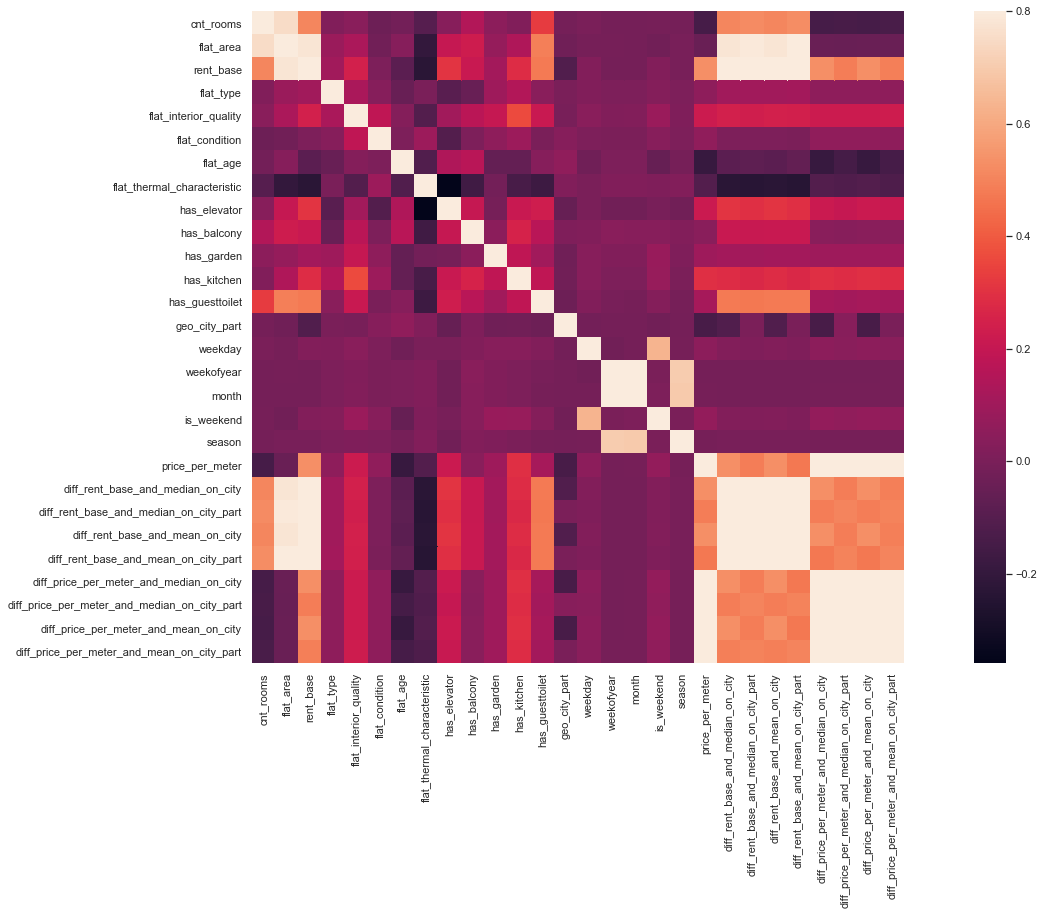

In [151]:
corrmatrix = prepared_df.corr()
f, ax = plt.subplots(figsize=(25, 12))
sns.heatmap(corrmatrix, vmax=.8, square=True)

## Naive LGBM



In [152]:
prepared_df.head()

,cnt_rooms,flat_area,rent_base,flat_type,flat_interior_quality,flat_condition,flat_age,flat_thermal_characteristic,has_elevator,has_balcony,...,season,price_per_meter,diff_rent_base_and_median_on_city,diff_rent_base_and_median_on_city_part,diff_rent_base_and_mean_on_city,diff_rent_base_and_mean_on_city_part,diff_price_per_meter_and_median_on_city,diff_price_per_meter_and_median_on_city_part,diff_price_per_meter_and_mean_on_city,diff_price_per_meter_and_mean_on_city_part
0,1,36.00,530.0,0,0,2,0,138.3,0,1,...,4,14.722222,-203.48,-175.0,-300.266037,-235.197589,2.722222,3.801142,2.270438,3.503997
1,2,70.00,1100.0,0,0,2,0,138.3,1,1,...,4,15.714286,366.52,390.5,269.733963,249.569464,3.714286,3.230536,3.262502,2.755372
2,2,62.13,1040.0,0,4,0,6,50.7,1,1,...,4,16.739095,306.52,181.0,209.733963,99.218124,4.739095,3.277557,4.287312,3.459849
3,2,75.00,675.0,7,0,2,4,104.0,0,1,...,4,9.000000,-58.48,-30.0,-155.266037,-90.197589,-3.000000,-1.921080,-3.451784,-2.218225
4,2,52.00,676.0,0,0,2,0,138.3,0,1,...,4,13.000000,-57.48,-119.0,-154.266037,-214.119940,1.000000,-0.416936,0.548216,-0.701492


In [153]:
import lightgbm as lgb

In [154]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from math import sqrt

In [155]:
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold, KFold

In [156]:
folds = KFold(n_splits=5, shuffle=False, random_state=11)

folds_idx = [(train_idx, val_idx) 
             for train_idx, val_idx in folds.split(prepared_df, y=y)]


In [157]:
params = {'num_leaves': 10,
         'min_data_in_leaf': 8, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 5,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 1337}

In [158]:
from sklearn.linear_model import Ridge

In [166]:
test_preds = []
oof_preds = np.zeros(prepared_df.shape[0])
mean_squared_errors = []
rmses = []
feature_importance_df = pd.DataFrame()
    
for n_fold, (train_idx, valid_idx) in enumerate(folds_idx):
    train_x, train_y = prepared_df.loc[train_idx], y.loc[train_idx]
    valid_x, valid_y = prepared_df.loc[valid_idx], y.loc[valid_idx]
    
    num_boost_round=1000
    early_stopping_rounds=250
    
    d_train = lgb.Dataset(train_x, label=train_y)
    d_valid = lgb.Dataset(valid_x, label=valid_y)
    clf = lgb.train(params,
                    d_train,
                    valid_sets=[d_train, d_valid], 
                    valid_names=['train','valid'], 
                    num_boost_round=num_boost_round,
                    early_stopping_rounds=early_stopping_rounds,
                    verbose_eval=200,
                   )
    ridge = Ridge()
    ridge.fit(train_x, train_y)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = prepared_df.columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    oof_preds[valid_idx] = clf.predict(valid_x)
    rmses.append(sqrt(mean_squared_error(valid_y, oof_preds[valid_idx])))
    
    print('Fold %2d RMSE Ridge: %.6f' % (n_fold + 1, sqrt(mean_squared_error(valid_y, ridge.predict(valid_x)))))
    
    
    print('Fold %2d RMSE : %.6f' % (n_fold + 1, rmses[-1]))
    print('Fold %2d RMSLE : %.6f' % (n_fold + 1, sqrt(mean_squared_log_error(valid_y, oof_preds[valid_idx]))))

    
print("\n", f"Mean RMSE:{np.mean(rmses)}")
print(f"std: {np.std(rmses)}")
print(f"OOF RMSLE:{sqrt(mean_squared_log_error(y, oof_preds))}")
print(f"OOF RMSE:{sqrt(mean_squared_error(y, oof_preds))}")

Training until validation scores don't improve for 250 rounds.
[200]	train's rmse: 168.827	valid's rmse: 100.755
[400]	train's rmse: 135.05	valid's rmse: 72.115
[600]	train's rmse: 123.937	valid's rmse: 70.754
[800]	train's rmse: 116.015	valid's rmse: 70.7031
Early stopping, best iteration is:
[719]	train's rmse: 119.363	valid's rmse: 70.3625
Fold  1 RMSE Ridge: 68.240784
Fold  1 RMSE : 70.362538
Fold  1 RMSLE : 0.092184
Training until validation scores don't improve for 250 rounds.
[200]	train's rmse: 106.241	valid's rmse: 292.365
[400]	train's rmse: 73.4632	valid's rmse: 282.439
[600]	train's rmse: 68.2023	valid's rmse: 281.807
[800]	train's rmse: 65.5	valid's rmse: 281.571
[1000]	train's rmse: 63.6724	valid's rmse: 281.402
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 63.6724	valid's rmse: 281.402
Fold  2 RMSE Ridge: 281.860866
Fold  2 RMSE : 281.401656
Fold  2 RMSLE : 0.268588
Training until validation scores don't improve for 250 rounds.
[200]	train's rmse: 

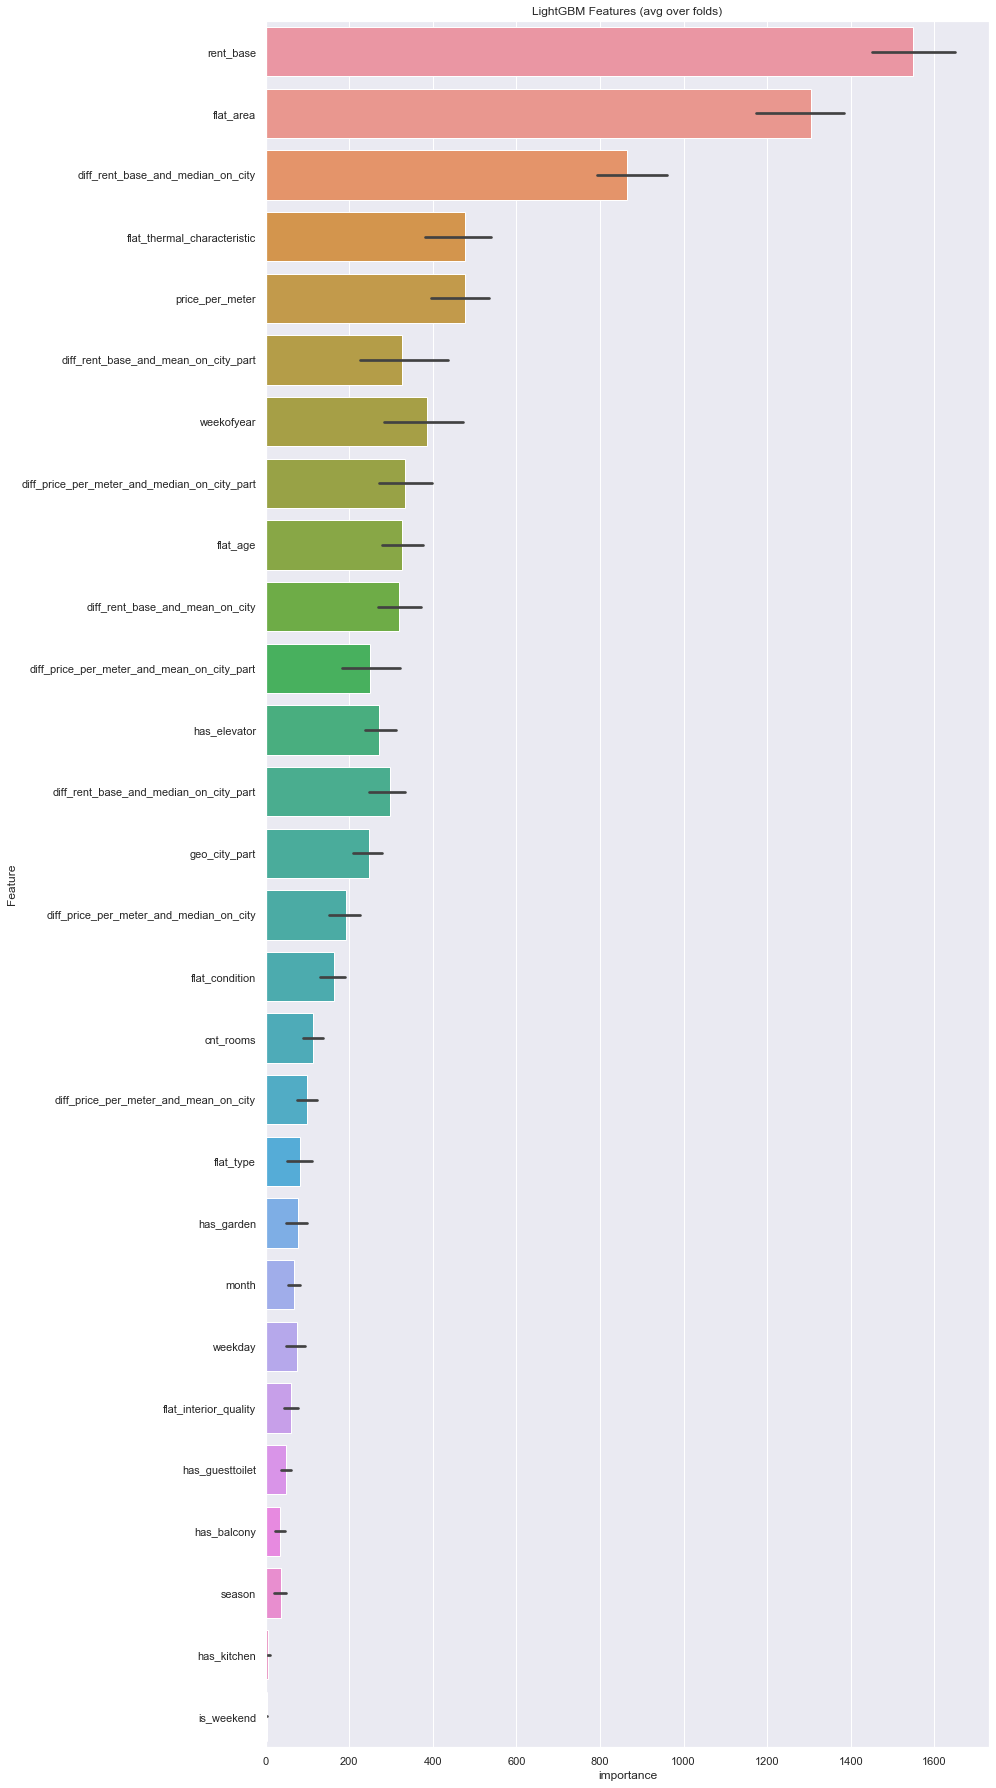

In [167]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

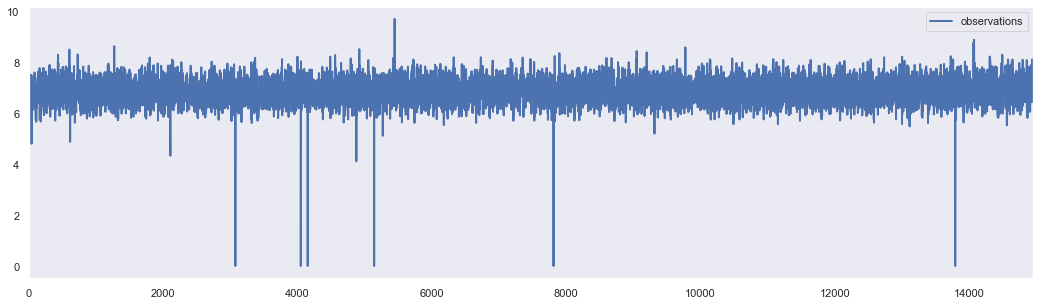

In [170]:
import matplotlib.pyplot as plt

np.log1p(data[["rent_total"]]).plot(figsize=(18, 5), linewidth=2)
plt.grid()
plt.legend(["observations"])
plt.show()